In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

#Настройки показа графиков в блокноте
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.width', 85)
pd.set_option('display.max_columns', 8)

from sklearn import preprocessing
#%config InlineBackend.figure_format = 'svg' для большей четкости графиков
matplotlib.style.use('ggplot')
%matplotlib inline

#Стандартизация данных
from sklearn import preprocessing

#Построение диаграмм рассеивания
from pandas.plotting import scatter_matrix

#Графика для интерпретации моделей
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call

from sklearn.model_selection import train_test_split

#Деревья решений для задачи классификации
from sklearn.tree import DecisionTreeClassifier

#Калибровка деревьев решений
from sklearn.calibration import CalibratedClassifierCV

df = pd.read_csv('train.csv')
tsd = pd.read_csv('test.csv')


In [2]:
df.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.00,38.00,26.00,35.00,35.00
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.28,7.92,53.10,8.05


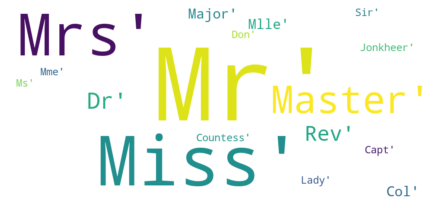

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Mme               1
Don               1
the Countess      1
Lady              1
Capt              1
Sir               1
Jonkheer          1
Ms                1
Name: Salutation, dtype: int64

In [3]:
df['Salutation'] = df.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
df.Salutation.nunique()
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(df.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

df.Salutation.value_counts()

In [4]:
df.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.00,38.00,26.00,35.00,35.00
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.28,7.92,53.10,8.05


In [5]:
#Меняем пропущенные значения на среднее значение по колонке 
grp = df.groupby(['Sex', 'Pclass'])  
df.Age = grp.Age.apply(lambda x: x.fillna(x.median()))

In [6]:
#Преобразуем объектные столбцы в численные. 
df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})

In [7]:
df.shape

(891, 13)

In [8]:
df.drop(['Cabin', 'Name', 'Salutation', 'Ticket','Embarked', 'SibSp', 'Parch'], axis=1, inplace=True)

In [9]:
df.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,1,22.00,7.25
1,1,1,0,38.00,71.28
2,1,3,0,26.00,7.92
3,1,1,0,35.00,53.10
4,0,3,1,35.00,8.05


In [10]:
X_to_be_predicted = df[df.Survived.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['Survived'], axis = 1)
# X_to_be_predicted[X_to_be_predicted.Age.isnull()]
# X_to_be_predicted.dropna(inplace = True) # 417 x 27
#Training data
train_data = df
train_data = train_data.dropna()
feature_train = train_data['Survived']
label_train = train_data.drop(['Survived'], axis = 1)

In [11]:
##Random forest
clf = RandomForestClassifier(criterion='entropy',
n_estimators=700,
min_samples_split=10,
min_samples_leaf=1,
max_features='auto',
oob_score=True,
random_state=1,
n_jobs=-1)
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train, np.ravel(y_train))
print("RF Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)

RF Accuracy: 84.92%
The cross validated score for Random forest is: 81.62


In [12]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,...,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,...,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,...,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,...,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,...,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,...,3101298,12.29,NaN,S
